# Analisis Sentimen ulasan Shopee

setelah dilakukan preproccesing, selain menggunakan pembobotan TFIDF, pada analisis ini juga menggunakan metode pembobotan Word2Vec. Berikut merupakan penjelasan analisis klasifikasi berdasrkan metode Support Vector Machine (SVM) dengan menggunakan Word2Vec. Metode kernel SVM yang digunakan pada analisis ini juga terdiri dari:



*   Kernel Linear
*   Kernel Radial Basis Function (RBF)



In [ ]:
#import library
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import classification_report, confusion_matrix
import codecs
from sklearn import model_selection
from sklearn.datasets import make_classification
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import precision_recall_curve, roc_auc_score
from sklearn.metrics import f1_score, roc_curve, auc
from sklearn.model_selection import StratifiedKFold

**Import data**

data yang digunakan pada pembobotan Word2Vec juga data setelah melalui tahap pre-processing yang digabungkan kembali menjadi satu kalimat (un-tokenize).

In [ ]:
#data untuk word2vec
import pandas as pd 
import numpy as np
data = pd.read_csv('shope_word2vec.csv', usecols =['content','Klasifikasi'])
data.dropna()
data.head(2)
len(data)

11255

In [ ]:
data['content']=data['content'].fillna("")

## Membentuk model Word2Vec

Pembobotan tersebut merupakan model swallow neural network merubah representasi kata yang merupakan kombinasi dari karakter alphanumeric menjadi vector dengan kata memiliki semantic meaning yang sama berada tidak jauh satu sama lain pada space tersebut. Terdapat dua macam model Word2Vec, yaitu Continuous Bag of Words (CBOW) dan Skip-Gram, dimana pada analisis ini menggunakan algoritma dari Skip-Gram Model. Penjelasan lebih lanjut mengenai metode Word2Vec untuk klasifikasi sentimen, dijelaskan pada beberapa link berikut:


*   [link 1](https://www.kaggle.com/code/nitin194/twitter-sentiment-analysis-word2vec-doc2vec)
*   [link 2](https://medium.com/swlh/sentiment-classification-using-word-embeddings-word2vec-aedf28fbb8ca)
*   [link 3](https://medium.com/@afrizalfir/mengenal-word2vec-af4758da6b5d)




In [ ]:
pip install gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#library yang digunakan untuk pembobotan Word2Vec
from gensim import corpora
from gensim import models
from gensim.models import LdaModel
from gensim.models import CoherenceModel
from gensim.models import Word2Vec

In [ ]:
#mendefinisikan variabel x dan y
x=data['content']
y=data['Klasifikasi']

In [ ]:
#build word2vec model
%%time
from sklearn.model_selection import train_test_split
tokenized_review = data['content'].apply(lambda x: x.split()) # tokenizing 

model_w2v = Word2Vec(
            tokenized_review,
            size=200, # desired no. of features/independent variables or you can call vector size of model 
            window=5, # context window size
            min_count=2, # Ignores all words with total frequency lower than 2.                                  
            sg = 1, # 1 for skip-gram model, if you want build model with CBOW, you have to use sg=0
            hs = 0,
            negative = 10, # for negative sampling
            workers= 32, # no.of cores
            seed = 34
) 

model_w2v.train(tokenized_review, total_examples= len(data['content']), epochs=20)

CPU times: user 53.8 s, sys: 328 ms, total: 54.1 s
Wall time: 34.4 s


In [ ]:
#We will use the below function to create a vector for each tweet by taking the average of the vectors of the words present in the review.
def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0
    for word in tokens:
        try:
            vec += model_w2v[word].reshape((1, size))
            count += 1.
        except KeyError:  # handling the case where the token is not in vocabulary
            continue
    if count != 0:
        vec /= count
    return vec

In [ ]:
#Preparing word2vec feature set
wordvec_arrays = np.zeros((len(tokenized_review), 200)) 
for i in range(len(tokenized_review)):
    wordvec_arrays[i,:] = word_vector(tokenized_review[i], 200)
wordvec_df = pd.DataFrame(wordvec_arrays)
wordvec_df.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


(11255, 200)

melakukan pembagian data training dan data testing dengan perbandingan 80:20.

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(x,y,train_size=0.8, random_state=0) 
print("training x_train: ",len(x_train))
print("training x_test: ",len(x_test))
print("training y_train: ",len(y_train))
print("training y_test: ",len(y_test))

training x_train:  9004
training x_test:  2251
training y_train:  9004
training y_test:  2251


Mengaplikasikan model Word2Vec yang terbentuk untuk pembobotan variabel ulasan (x).

In [ ]:
x = wordvec_df.iloc[:,:]
xtrain_w2v = x.iloc[y_train.index,:]
xtest_w2v = x.iloc[y_test.index,:]
print(xtest_w2v)

           0         1         2         3         4         5         6    \
5006 -0.001988  0.178461 -0.089490  0.019366  0.293862  0.052088 -0.303046   
812   0.031681  0.280917 -0.197792 -0.005823  0.130823 -0.151765 -0.265741   
125   0.083571  0.056731 -0.073964  0.078569  0.077500  0.069306 -0.173151   
1765 -0.003017  0.106707  0.013057  0.113291  0.117175 -0.042358 -0.196463   
4861  0.133728  0.349135 -0.067848 -0.175156 -0.077398  0.047298 -0.317040   
...        ...       ...       ...       ...       ...       ...       ...   
6166 -0.000006  0.141060 -0.055292 -0.082940  0.019327  0.022739 -0.259451   
1231  0.016451  0.323514 -0.271262  0.067867  0.153786 -0.112707 -0.207681   
7617 -0.088144  0.114536  0.055101  0.038914  0.108074 -0.069724 -0.067553   
8276  0.085414  0.177044 -0.111949 -0.026292  0.060286 -0.080956 -0.165876   
4556 -0.013320  0.187971  0.109459  0.278520  0.225542 -0.028755 -0.303221   

           7         8         9    ...       190       191    

# Support Vector Machine (SVM) Kernel Linear

Setelah dilakukan pembobotan menggunakan Word2Vec, maka langkah selanjutnya yaitu melakukan analisis klasifikasi menggunakan SVM, dimana untuk kernel yang digunakan saat ini yaitu kernel Linear.

Sama seperti metode pembobotan TFIDF, setelah data ulasan sudah dilakukan pembobotan dengan Word2Vec, maka langkah pertama yaitu melakukan penentuan parameter terbaik dengan metode Grid Search. Berikut merupakan code Grid Search dengan menggunakan kombinasi nilai 10^-1, 1, 10.

In [ ]:
tuned_parameters = [{'kernel':['linear'], 'C':[0.1, 1, 10]}]
scores = ['recall']
for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()
    tuned = GridSearchCV(SVC(), tuned_parameters, scoring='roc_auc')
    tuned.fit(xtrain_w2v, y_train)
    print("Best parameters set found on development set:")
    print()
    print(tuned.best_params_)
    print(tuned.best_score_)
    print()
    print("Grid scores on development set:")
    print()
    means = tuned.cv_results_['mean_test_score']
    stds = tuned.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, tuned.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"% (mean, std * 2, params))

# Tuning hyper-parameters for recall

Best parameters set found on development set:

{'C': 0.1, 'kernel': 'linear'}
0.8940873981398785

Grid scores on development set:

0.894 (+/-0.013) for {'C': 0.1, 'kernel': 'linear'}
0.893 (+/-0.013) for {'C': 1, 'kernel': 'linear'}
0.891 (+/-0.014) for {'C': 10, 'kernel': 'linear'}


Berdasarkan metode Grid Search, diperoleh parameter terbaik untuk data ulasan Shopee menggunakan SVM kernel Linear yaitu C=0.1. Karena kekurangan dari code tersebut, tidak diketahui nilai akurasi dan nilai AUC, maka untuk langkah selanjutnya yaitu melakukan analisis klasifikasi SVM kernel Linear dengan kombinasi nilai parameter C sebesar 10^-1, 1, dan 10. 

**Tambahan:**
karena perbandingan label kelas positif dan negatif 53:47, maka untuk analisis ini saya menggunakan metode *Stratified K-Fold*, agar setiap data training dan testing memiliki distribusi variabel label kelas yang seimbang.


In [ ]:
skf = StratifiedKFold(n_splits=10, random_state=0, shuffle=True)
skf.get_n_splits(x, y)
i = 1
for train_index, test_index in skf.split(x, y) :
    print("Fold ",i)
    print("TRAIN :",train_index,"TEST :",test_index)
    xtrain_w2v ,xtest_w2v=x.iloc[train_index] ,x.iloc[test_index]
    y_train, y_test=y[train_index], y[test_index]
    i+=1
    modellin = SVC(kernel='linear', probability=True, C=0.1)
    clf_lin = modellin.fit(xtrain_w2v, y_train)
    pred_labels_tr = modellin.predict(xtrain_w2v)
    pred_labels_te = modellin.predict(xtest_w2v)
    cm_train = confusion_matrix(y_train, pred_labels_tr)
    cm_test = confusion_matrix(y_test, pred_labels_te)
    print('----- Evaluation on Training Data -----')
    score_tr = modellin.score(xtrain_w2v, y_train)
    print(classification_report(y_train, pred_labels_tr))
    print('--------------------------------------------------------')
    print("Accuracy Train = {:.2f}%".format(score_tr*100))
    print("AUC Train: ", roc_auc_score(y_train, pred_labels_tr))
    print("CM Train = ")
    print(cm_train)
    print()
    print('----- Evaluation on Test Data -----')
    score_te = modellin.score(xtest_w2v, y_test)
    print(classification_report(y_test, pred_labels_te))
    print('--------------------------------------------------------')
    print("Accuracy Test = {:.2f}%".format(score_te*100))
    print("AUC Test: ", roc_auc_score(y_test,pred_labels_te))
    print("CM Test = ")
    print(cm_test)
    print('--------------------------------------------------------')
    print('w = ',clf_lin.coef_)
    print('b = ',clf_lin.intercept_)
    print('Indices of support vectors = ', clf_lin.support_)

Fold  1
TRAIN : [    0     1     2 ... 11252 11253 11254] TEST : [   12    14    41 ... 11229 11242 11244]
----- Evaluation on Training Data -----
              precision    recall  f1-score   support

           0       0.78      0.90      0.83      4746
           1       0.90      0.78      0.83      5383

    accuracy                           0.83     10129
   macro avg       0.84      0.84      0.83     10129
weighted avg       0.84      0.83      0.83     10129

--------------------------------------------------------
Accuracy Train = 83.34%
AUC Train:  0.8373064279165756
CM Train = 
[[4265  481]
 [1206 4177]]

----- Evaluation on Test Data -----
              precision    recall  f1-score   support

           0       0.78      0.89      0.83       527
           1       0.89      0.78      0.83       599

    accuracy                           0.83      1126
   macro avg       0.83      0.83      0.83      1126
weighted avg       0.84      0.83      0.83      1126

-----------

In [ ]:
skf = StratifiedKFold(n_splits=10, random_state=0, shuffle=True)
skf.get_n_splits(x, y)
i = 1
for train_index, test_index in skf.split(x, y) :
    print("Fold ",i)
    print("TRAIN :",train_index,"TEST :",test_index)
    xtrain_w2v ,xtest_w2v=x.iloc[train_index] ,x.iloc[test_index]
    y_train, y_test=y[train_index], y[test_index]
    i+=1
    modellin = SVC(kernel='linear', probability=True, C=1)
    clf_lin = modellin.fit(xtrain_w2v, y_train)
    pred_labels_tr = modellin.predict(xtrain_w2v)
    pred_labels_te = modellin.predict(xtest_w2v)
    cm_train = confusion_matrix(y_train, pred_labels_tr)
    cm_test = confusion_matrix(y_test, pred_labels_te)
    print('----- Evaluation on Training Data -----')
    score_tr = modellin.score(xtrain_w2v, y_train)
    print(classification_report(y_train, pred_labels_tr))
    print('--------------------------------------------------------')
    print("Accuracy Train = {:.2f}%".format(score_tr*100))
    print("AUC Train: ", roc_auc_score(y_train, pred_labels_tr))
    print("CM Train = ")
    print(cm_train)
    print()
    print('----- Evaluation on Test Data -----')
    score_te = modellin.score(xtest_w2v, y_test)
    print(classification_report(y_test, pred_labels_te))
    print('--------------------------------------------------------')
    print("Accuracy Test = {:.2f}%".format(score_te*100))
    print("AUC Test: ", roc_auc_score(y_test,pred_labels_te))
    print("CM Test = ")
    print(cm_test)
    print('--------------------------------------------------------')
    print('w = ',clf_lin.coef_)
    print('b = ',clf_lin.intercept_)
    print('Indices of support vectors = ', clf_lin.support_)

Fold  1
TRAIN : [    0     1     2 ... 11252 11253 11254] TEST : [   12    14    41 ... 11229 11242 11244]
----- Evaluation on Training Data -----
              precision    recall  f1-score   support

           0       0.79      0.89      0.84      4746
           1       0.89      0.79      0.84      5383

    accuracy                           0.84     10129
   macro avg       0.84      0.84      0.84     10129
weighted avg       0.84      0.84      0.84     10129

--------------------------------------------------------
Accuracy Train = 83.70%
AUC Train:  0.8403884840125447
CM Train = 
[[4244  502]
 [1149 4234]]

----- Evaluation on Test Data -----
              precision    recall  f1-score   support

           0       0.79      0.89      0.83       527
           1       0.89      0.79      0.83       599

    accuracy                           0.83      1126
   macro avg       0.84      0.84      0.83      1126
weighted avg       0.84      0.83      0.83      1126

-----------

In [ ]:
skf = StratifiedKFold(n_splits=10, random_state=0, shuffle=True)
skf.get_n_splits(x, y)
i = 1
for train_index, test_index in skf.split(x, y) :
    print("Fold ",i)
    print("TRAIN :",train_index,"TEST :",test_index)
    xtrain_w2v ,xtest_w2v=x.iloc[train_index] ,x.iloc[test_index]
    y_train, y_test=y[train_index], y[test_index]
    i+=1
    modellin = SVC(kernel='linear', probability=True, C=10)
    clf_lin = modellin.fit(xtrain_w2v, y_train)
    pred_labels_tr = modellin.predict(xtrain_w2v)
    pred_labels_te = modellin.predict(xtest_w2v)
    cm_train = confusion_matrix(y_train, pred_labels_tr)
    cm_test = confusion_matrix(y_test, pred_labels_te)
    print('----- Evaluation on Training Data -----')
    score_tr = modellin.score(xtrain_w2v, y_train)
    print(classification_report(y_train, pred_labels_tr))
    print('--------------------------------------------------------')
    print("Accuracy Train = {:.2f}%".format(score_tr*100))
    print("AUC Train: ", roc_auc_score(y_train, pred_labels_tr))
    print("CM Train = ")
    print(cm_train)
    print()
    print('----- Evaluation on Test Data -----')
    score_te = modellin.score(xtest_w2v, y_test)
    print(classification_report(y_test, pred_labels_te))
    print('--------------------------------------------------------')
    print("Accuracy Test = {:.2f}%".format(score_te*100))
    print("AUC Test: ", roc_auc_score(y_test,pred_labels_te))
    print("CM Test = ")
    print(cm_test)
    print('--------------------------------------------------------')
    print('w = ',clf_lin.coef_)
    print('b = ',clf_lin.intercept_)
    print('Indices of support vectors = ', clf_lin.support_)

Fold  1
TRAIN : [    0     1     2 ... 11252 11253 11254] TEST : [   12    14    41 ... 11229 11242 11244]
----- Evaluation on Training Data -----
              precision    recall  f1-score   support

           0       0.79      0.89      0.84      4746
           1       0.89      0.79      0.84      5383

    accuracy                           0.84     10129
   macro avg       0.84      0.84      0.84     10129
weighted avg       0.84      0.84      0.84     10129

--------------------------------------------------------
Accuracy Train = 83.82%
AUC Train:  0.8413909023107269
CM Train = 
[[4235  511]
 [1128 4255]]

----- Evaluation on Test Data -----
              precision    recall  f1-score   support

           0       0.79      0.88      0.83       527
           1       0.88      0.80      0.84       599

    accuracy                           0.84      1126
   macro avg       0.84      0.84      0.84      1126
weighted avg       0.84      0.84      0.84      1126

-----------

Berikut merupakan hasil analisis klasiifikasi SVM kernel Linear dengan kombinasi nilai parameter C sebesar 10^-1, 1, dan 10.

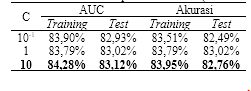

Berdasarkan hasil analisis klasifikasi SVM kernel Linear dengan menggunakan percobaan nilai parameter C sama dengan 10^-1, 1 dan 10, diperoleh nilai parameter yang menghasilkan nilai akurasi dan nilai AUC terbaik adalah ketika nilai parameter C = 10, hasil tersebut tidak sesuai dengan hasil metode Grid Search. 

# Support Vector Machine (SVM) kernel RBF

Langkah pertama yaitu menentukan nilai parameter terbaik menggunakan metode Grid Search dengan kominasi nilai parameter C dan Gamma sebesar 10^-1, 1, dan 10.

In [ ]:
#mendefiniskan variabel x dan y untuk kernel BRF
x_w2v_rbf= x
y_rbf= y
xtrain_w2v_rbf= xtrain_w2v
xtest_w2v_rbf= xtest_w2v
y_train_rbf= y_train
y_test_rbf= y_test

In [ ]:
tuned_parameters_rbf = [{'kernel':['rbf'], 'C':[ 0.1, 1, 10], 'gamma': [0.1, 1, 10]}]
scores_rbf = ['recall']
for score_rbf in scores_rbf:
    print('# Tuning hyper-parameters for %s' % score_rbf)
    print()
    tuned_rbf = GridSearchCV(SVC(), tuned_parameters_rbf, scoring='roc_auc')
    tuned_rbf.fit(xtrain_w2v_rbf, y_train_rbf)
    print("Best parameters set found on development set:")
    print()
    print(tuned_rbf.best_params_)
    print(tuned_rbf.best_score_)
    print()
    print("Grid scores on development set:")
    print()
    means_rbf = tuned_rbf.cv_results_['mean_test_score']
    stds_rbf = tuned_rbf.cv_results_['std_test_score']
for mean_rbf, std_rbf, params_rbf in zip(means_rbf, stds_rbf, tuned_rbf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"% (mean_rbf, std_rbf * 2, params_rbf))

# Tuning hyper-parameters for recall

Best parameters set found on development set:

{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
0.9042755887921212

Grid scores on development set:

0.896 (+/-0.042) for {'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}
0.894 (+/-0.040) for {'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}
0.826 (+/-0.049) for {'C': 0.1, 'gamma': 10, 'kernel': 'rbf'}
0.904 (+/-0.036) for {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
0.903 (+/-0.034) for {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
0.826 (+/-0.049) for {'C': 1, 'gamma': 10, 'kernel': 'rbf'}
0.904 (+/-0.033) for {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
0.891 (+/-0.034) for {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
0.826 (+/-0.048) for {'C': 10, 'gamma': 10, 'kernel': 'rbf'}


Berdasarkan hasil metode Grid Search diperoleh kombinasi nilai C dan Gamma terbaik sebesar 1. Kemudian sama seperti pada kernel Linear, karena kekurangan dari code tersebut tidak diketahui nilai akurasi dan nilai AUC, maka langkah selanjutnya yaitu melakukan analisis klasifikasi SVM kernel RBF dengan kombinasi nilai parameter C dan Gamma sebesar 10^-1, 1 dan 10.

In [ ]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=10, random_state=0, shuffle=True)
skf.get_n_splits(x_w2v_rbf, y_rbf)
i = 1
for train_index, test_index in skf.split(x_w2v_rbf, y_rbf) :
    print("Fold ",i)
    print("TRAIN :",train_index,"TEST :",test_index)
    x_train_rbf ,x_test_rbf=x_w2v_rbf.iloc[train_index] ,x_w2v_rbf.iloc[test_index]
    y_train_rbf, y_test_rbf=y_rbf[train_index], y_rbf[test_index]
    i+=1
    modellin = SVC(kernel='rbf', probability=True, C=0.1, gamma=0.1)
    clf_lin = modellin.fit(x_train_rbf, y_train_rbf)
    pred_labels_tr = modellin.predict(x_train_rbf)
    pred_labels_te = modellin.predict(x_test_rbf)
    cm_train = confusion_matrix(y_train_rbf, pred_labels_tr)
    cm_test = confusion_matrix(y_test_rbf, pred_labels_te)
    print('----- Evaluation on Training Data -----')
    score_tr = modellin.score(x_train_rbf, y_train_rbf)
    print(classification_report(y_train_rbf, pred_labels_tr))
    print('--------------------------------------------------------')
    print("Accuracy Train = {:.2f}%".format(score_tr*100))
    print("AUC Train: ", roc_auc_score(y_train_rbf, pred_labels_tr))
    print("CM Train = ")
    print(cm_train)
    print('----- Evaluation on Test Data -----')
    score_te = modellin.score(x_test_rbf, y_test_rbf)
    print(classification_report(y_test_rbf, pred_labels_te))
    print('--------------------------------------------------------')
    print("Accuracy Test = {:.2f}%".format(score_te*100))
    print("AUC Test: ", roc_auc_score(y_test_rbf,pred_labels_te))
    print("CM Test = ")
    print(cm_test)
    print('--------------------------------------------------------')
    print('b = ',clf_lin.intercept_)
    print('Indices of support vectors = ', clf_lin.support_)
    print('Number of support vectors for each class = ', clf_lin.n_support_)
    print('Coefficients of the support vector in the decision function =',np.abs(clf_lin.dual_coef_))
    print('--------------------------------------------------------')

Fold  1
TRAIN : [    0     1     2 ... 11252 11253 11254] TEST : [   12    14    41 ... 11229 11242 11244]
----- Evaluation on Training Data -----
              precision    recall  f1-score   support

           0       0.76      0.92      0.83      4746
           1       0.91      0.75      0.82      5383

    accuracy                           0.83     10129
   macro avg       0.84      0.83      0.83     10129
weighted avg       0.84      0.83      0.83     10129

--------------------------------------------------------
Accuracy Train = 82.90%
AUC Train:  0.8343608223638604
CM Train = 
[[4364  382]
 [1350 4033]]
----- Evaluation on Test Data -----
              precision    recall  f1-score   support

           0       0.77      0.92      0.84       527
           1       0.92      0.75      0.83       599

    accuracy                           0.83      1126
   macro avg       0.84      0.84      0.83      1126
weighted avg       0.85      0.83      0.83      1126

------------

In [ ]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=10, random_state=0, shuffle=True)
skf.get_n_splits(x_w2v_rbf, y_rbf)
i = 1
for train_index, test_index in skf.split(x_w2v_rbf, y_rbf) :
    print("Fold ",i)
    print("TRAIN :",train_index,"TEST :",test_index)
    x_train_rbf ,x_test_rbf=x_w2v_rbf.iloc[train_index] ,x_w2v_rbf.iloc[test_index]
    y_train_rbf, y_test_rbf=y_rbf[train_index], y_rbf[test_index]
    i+=1
    modellin = SVC(kernel='rbf', probability=True, C=0.1, gamma=1)
    clf_lin = modellin.fit(x_train_rbf, y_train_rbf)
    pred_labels_tr = modellin.predict(x_train_rbf)
    pred_labels_te = modellin.predict(x_test_rbf)
    cm_train = confusion_matrix(y_train_rbf, pred_labels_tr)
    cm_test = confusion_matrix(y_test_rbf, pred_labels_te)
    print('----- Evaluation on Training Data -----')
    score_tr = modellin.score(x_train_rbf, y_train_rbf)
    print(classification_report(y_train_rbf, pred_labels_tr))
    print('--------------------------------------------------------')
    print("Accuracy Train = {:.2f}%".format(score_tr*100))
    print("AUC Train: ", roc_auc_score(y_train_rbf, pred_labels_tr))
    print("CM Train = ")
    print(cm_train)
    print('----- Evaluation on Test Data -----')
    score_te = modellin.score(x_test_rbf, y_test_rbf)
    print(classification_report(y_test_rbf, pred_labels_te))
    print('--------------------------------------------------------')
    print("Accuracy Test = {:.2f}%".format(score_te*100))
    print("AUC Test: ", roc_auc_score(y_test_rbf,pred_labels_te))
    print("CM Test = ")
    print(cm_test)
    print('--------------------------------------------------------')
    print('b = ',clf_lin.intercept_)
    print('Indices of support vectors = ', clf_lin.support_)
    print('Number of support vectors for each class = ', clf_lin.n_support_)
    print('Coefficients of the support vector in the decision function =',np.abs(clf_lin.dual_coef_))
    print('--------------------------------------------------------')

Fold  1
TRAIN : [    0     1     2 ... 11252 11253 11254] TEST : [   12    14    41 ... 11229 11242 11244]
----- Evaluation on Training Data -----
              precision    recall  f1-score   support

           0       0.79      0.94      0.86      4746
           1       0.93      0.78      0.85      5383

    accuracy                           0.85     10129
   macro avg       0.86      0.86      0.85     10129
weighted avg       0.86      0.85      0.85     10129

--------------------------------------------------------
Accuracy Train = 85.12%
AUC Train:  0.8563196329315989
CM Train = 
[[4449  297]
 [1210 4173]]
----- Evaluation on Test Data -----
              precision    recall  f1-score   support

           0       0.78      0.92      0.84       527
           1       0.92      0.77      0.83       599

    accuracy                           0.84      1126
   macro avg       0.85      0.84      0.84      1126
weighted avg       0.85      0.84      0.84      1126

------------

In [ ]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=10, random_state=0, shuffle=True)
skf.get_n_splits(x_w2v_rbf, y_rbf)
i = 1
for train_index, test_index in skf.split(x_w2v_rbf, y_rbf) :
    print("Fold ",i)
    print("TRAIN :",train_index,"TEST :",test_index)
    x_train_rbf ,x_test_rbf=x_w2v_rbf.iloc[train_index] ,x_w2v_rbf.iloc[test_index]
    y_train_rbf, y_test_rbf=y_rbf[train_index], y_rbf[test_index]
    i+=1
    modellin = SVC(kernel='rbf', probability=True, C=0.1, gamma=10)
    clf_lin = modellin.fit(x_train_rbf, y_train_rbf)
    pred_labels_tr = modellin.predict(x_train_rbf)
    pred_labels_te = modellin.predict(x_test_rbf)
    cm_train = confusion_matrix(y_train_rbf, pred_labels_tr)
    cm_test = confusion_matrix(y_test_rbf, pred_labels_te)
    print('----- Evaluation on Training Data -----')
    score_tr = modellin.score(x_train_rbf, y_train_rbf)
    print(classification_report(y_train_rbf, pred_labels_tr))
    print('--------------------------------------------------------')
    print("Accuracy Train = {:.2f}%".format(score_tr*100))
    print("AUC Train: ", roc_auc_score(y_train_rbf, pred_labels_tr))
    print("CM Train = ")
    print(cm_train)
    print('----- Evaluation on Test Data -----')
    score_te = modellin.score(x_test_rbf, y_test_rbf)
    print(classification_report(y_test_rbf, pred_labels_te))
    print('--------------------------------------------------------')
    print("Accuracy Test = {:.2f}%".format(score_te*100))
    print("AUC Test: ", roc_auc_score(y_test_rbf,pred_labels_te))
    print("CM Test = ")
    print(cm_test)
    print('--------------------------------------------------------')
    print('b = ',clf_lin.intercept_)
    print('Indices of support vectors = ', clf_lin.support_)
    print('Number of support vectors for each class = ', clf_lin.n_support_)
    print('Coefficients of the support vector in the decision function =',np.abs(clf_lin.dual_coef_))
    print('--------------------------------------------------------')

Fold  1
TRAIN : [    0     1     2 ... 11252 11253 11254] TEST : [   12    14    41 ... 11229 11242 11244]
----- Evaluation on Training Data -----


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00      4746
           1       0.53      1.00      0.69      5383

    accuracy                           0.53     10129
   macro avg       0.27      0.50      0.35     10129
weighted avg       0.28      0.53      0.37     10129

--------------------------------------------------------
Accuracy Train = 53.14%
AUC Train:  0.5
CM Train = 
[[   0 4746]
 [   0 5383]]
----- Evaluation on Test Data -----


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       527
           1       0.53      1.00      0.69       599

    accuracy                           0.53      1126
   macro avg       0.27      0.50      0.35      1126
weighted avg       0.28      0.53      0.37      1126

--------------------------------------------------------
Accuracy Test = 53.20%
AUC Test:  0.5
CM Test = 
[[  0 527]
 [  0 599]]
--------------------------------------------------------
b =  [0.91061047]
Indices of support vectors =  [    1     2     3 ... 10121 10124 10128]
Number of support vectors for each class =  [4746 5346]
Coefficients of the support vector in the decision function = [[0.1        0.1        0.1        ... 0.08979037 0.08917982 0.08905676]]
--------------------------------------------------------
Fold  2
TRAIN : [    0     1     2 ... 11252 11253 11254] TEST : [   10    23    26 ... 11226 11237 11251]
----- Evaluation on Training Data -----


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00      4746
           1       0.53      1.00      0.69      5383

    accuracy                           0.53     10129
   macro avg       0.27      0.50      0.35     10129
weighted avg       0.28      0.53      0.37     10129

--------------------------------------------------------
Accuracy Train = 53.14%
AUC Train:  0.5
CM Train = 
[[   0 4746]
 [   0 5383]]
----- Evaluation on Test Data -----


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       527
           1       0.53      1.00      0.69       599

    accuracy                           0.53      1126
   macro avg       0.27      0.50      0.35      1126
weighted avg       0.28      0.53      0.37      1126

--------------------------------------------------------
Accuracy Test = 53.20%
AUC Test:  0.5
CM Test = 
[[  0 527]
 [  0 599]]
--------------------------------------------------------
b =  [0.91061983]
Indices of support vectors =  [    1     2     3 ... 10122 10125 10128]
Number of support vectors for each class =  [4746 5345]
Coefficients of the support vector in the decision function = [[0.1        0.1        0.1        ... 0.08914451 0.08914504 0.08919585]]
--------------------------------------------------------
Fold  3
TRAIN : [    0     1     2 ... 11252 11253 11254] TEST : [    4     9    11 ... 11212 11247 11248]
----- Evaluation on Training Data -----


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00      4745
           1       0.53      1.00      0.69      5384

    accuracy                           0.53     10129
   macro avg       0.27      0.50      0.35     10129
weighted avg       0.28      0.53      0.37     10129

--------------------------------------------------------
Accuracy Train = 53.15%
AUC Train:  0.5
CM Train = 
[[   0 4745]
 [   0 5384]]
----- Evaluation on Test Data -----


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       528
           1       0.53      1.00      0.69       598

    accuracy                           0.53      1126
   macro avg       0.27      0.50      0.35      1126
weighted avg       0.28      0.53      0.37      1126

--------------------------------------------------------
Accuracy Test = 53.11%
AUC Test:  0.5
CM Test = 
[[  0 528]
 [  0 598]]
--------------------------------------------------------
b =  [0.91054021]
Indices of support vectors =  [    1     2     3 ... 10122 10124 10128]
Number of support vectors for each class =  [4745 5343]
Coefficients of the support vector in the decision function = [[0.1        0.1        0.1        ... 0.08857604 0.08972949 0.08910659]]
--------------------------------------------------------
Fold  4
TRAIN : [    0     1     2 ... 11252 11253 11254] TEST : [    3    44    62 ... 11227 11238 11249]
----- Evaluation on Training Data -----


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00      4745
           1       0.53      1.00      0.69      5384

    accuracy                           0.53     10129
   macro avg       0.27      0.50      0.35     10129
weighted avg       0.28      0.53      0.37     10129

--------------------------------------------------------
Accuracy Train = 53.15%
AUC Train:  0.5
CM Train = 
[[   0 4745]
 [   0 5384]]
----- Evaluation on Test Data -----


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       528
           1       0.53      1.00      0.69       598

    accuracy                           0.53      1126
   macro avg       0.27      0.50      0.35      1126
weighted avg       0.28      0.53      0.37      1126

--------------------------------------------------------
Accuracy Test = 53.11%
AUC Test:  0.5
CM Test = 
[[  0 528]
 [  0 598]]
--------------------------------------------------------
b =  [0.91060724]
Indices of support vectors =  [    1     2     4 ... 10122 10124 10128]
Number of support vectors for each class =  [4745 5343]
Coefficients of the support vector in the decision function = [[0.1        0.1        0.1        ... 0.08979472 0.08974718 0.08926273]]
--------------------------------------------------------
Fold  5
TRAIN : [    0     1     3 ... 11249 11251 11253] TEST : [    2     7    16 ... 11250 11252 11254]
----- Evaluation on Training Data -----


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00      4745
           1       0.53      1.00      0.69      5384

    accuracy                           0.53     10129
   macro avg       0.27      0.50      0.35     10129
weighted avg       0.28      0.53      0.37     10129

--------------------------------------------------------
Accuracy Train = 53.15%
AUC Train:  0.5
CM Train = 
[[   0 4745]
 [   0 5384]]
----- Evaluation on Test Data -----


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       528
           1       0.53      1.00      0.69       598

    accuracy                           0.53      1126
   macro avg       0.27      0.50      0.35      1126
weighted avg       0.28      0.53      0.37      1126

--------------------------------------------------------
Accuracy Test = 53.11%
AUC Test:  0.5
CM Test = 
[[  0 528]
 [  0 598]]
--------------------------------------------------------
b =  [0.91063365]
Indices of support vectors =  [    1     2     4 ... 10119 10123 10124]
Number of support vectors for each class =  [4745 5345]
Coefficients of the support vector in the decision function = [[0.1        0.1        0.1        ... 0.08957171 0.0886349  0.08914484]]
--------------------------------------------------------
Fold  6
TRAIN : [    0     1     2 ... 11252 11253 11254] TEST : [    5    15    19 ... 11231 11232 11246]
----- Evaluation on Training Data -----


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00      4746
           1       0.53      1.00      0.69      5384

    accuracy                           0.53     10130
   macro avg       0.27      0.50      0.35     10130
weighted avg       0.28      0.53      0.37     10130

--------------------------------------------------------
Accuracy Train = 53.15%
AUC Train:  0.5
CM Train = 
[[   0 4746]
 [   0 5384]]
----- Evaluation on Test Data -----


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       527
           1       0.53      1.00      0.69       598

    accuracy                           0.53      1125
   macro avg       0.27      0.50      0.35      1125
weighted avg       0.28      0.53      0.37      1125

--------------------------------------------------------
Accuracy Test = 53.16%
AUC Test:  0.5
CM Test = 
[[  0 527]
 [  0 598]]
--------------------------------------------------------
b =  [0.91062575]
Indices of support vectors =  [    1     2     3 ... 10122 10125 10129]
Number of support vectors for each class =  [4746 5348]
Coefficients of the support vector in the decision function = [[0.1        0.1        0.1        ... 0.0891416  0.08916729 0.08926314]]
--------------------------------------------------------
Fold  7
TRAIN : [    0     1     2 ... 11252 11253 11254] TEST : [    8    20    31 ... 11198 11204 11206]
----- Evaluation on Training Data -----


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00      4746
           1       0.53      1.00      0.69      5384

    accuracy                           0.53     10130
   macro avg       0.27      0.50      0.35     10130
weighted avg       0.28      0.53      0.37     10130

--------------------------------------------------------
Accuracy Train = 53.15%
AUC Train:  0.5
CM Train = 
[[   0 4746]
 [   0 5384]]
----- Evaluation on Test Data -----


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       527
           1       0.53      1.00      0.69       598

    accuracy                           0.53      1125
   macro avg       0.27      0.50      0.35      1125
weighted avg       0.28      0.53      0.37      1125

--------------------------------------------------------
Accuracy Test = 53.16%
AUC Test:  0.5
CM Test = 
[[  0 527]
 [  0 598]]
--------------------------------------------------------
b =  [0.91062248]
Indices of support vectors =  [    1     2     3 ... 10122 10125 10129]
Number of support vectors for each class =  [4746 5348]
Coefficients of the support vector in the decision function = [[0.1        0.1        0.1        ... 0.08915841 0.08914933 0.08905545]]
--------------------------------------------------------
Fold  8
TRAIN : [    0     1     2 ... 11252 11253 11254] TEST : [   13    21    24 ... 11218 11236 11245]
----- Evaluation on Training Data -----


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00      4746
           1       0.53      1.00      0.69      5384

    accuracy                           0.53     10130
   macro avg       0.27      0.50      0.35     10130
weighted avg       0.28      0.53      0.37     10130

--------------------------------------------------------
Accuracy Train = 53.15%
AUC Train:  0.5
CM Train = 
[[   0 4746]
 [   0 5384]]
----- Evaluation on Test Data -----


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       527
           1       0.53      1.00      0.69       598

    accuracy                           0.53      1125
   macro avg       0.27      0.50      0.35      1125
weighted avg       0.28      0.53      0.37      1125

--------------------------------------------------------
Accuracy Test = 53.16%
AUC Test:  0.5
CM Test = 
[[  0 527]
 [  0 598]]
--------------------------------------------------------
b =  [0.91074788]
Indices of support vectors =  [    1     2     3 ... 10122 10125 10129]
Number of support vectors for each class =  [4746 5349]
Coefficients of the support vector in the decision function = [[0.1        0.1        0.1        ... 0.0891334  0.08913501 0.08914065]]
--------------------------------------------------------
Fold  9
TRAIN : [    0     2     3 ... 11252 11253 11254] TEST : [    1     6    18 ... 11230 11240 11241]
----- Evaluation on Training Data -----


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00      4746
           1       0.53      1.00      0.69      5384

    accuracy                           0.53     10130
   macro avg       0.27      0.50      0.35     10130
weighted avg       0.28      0.53      0.37     10130

--------------------------------------------------------
Accuracy Train = 53.15%
AUC Train:  0.5
CM Train = 
[[   0 4746]
 [   0 5384]]
----- Evaluation on Test Data -----


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       527
           1       0.53      1.00      0.69       598

    accuracy                           0.53      1125
   macro avg       0.27      0.50      0.35      1125
weighted avg       0.28      0.53      0.37      1125

--------------------------------------------------------
Accuracy Test = 53.16%
AUC Test:  0.5
CM Test = 
[[  0 527]
 [  0 598]]
--------------------------------------------------------
b =  [0.91070356]
Indices of support vectors =  [    1     2     4 ... 10122 10125 10129]
Number of support vectors for each class =  [4746 5349]
Coefficients of the support vector in the decision function = [[0.1        0.1        0.1        ... 0.08913202 0.08913596 0.08922598]]
--------------------------------------------------------
Fold  10
TRAIN : [    1     2     3 ... 11251 11252 11254] TEST : [    0    30    34 ... 11235 11239 11253]
----- Evaluation on Training Data -----


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00      4746
           1       0.53      1.00      0.69      5384

    accuracy                           0.53     10130
   macro avg       0.27      0.50      0.35     10130
weighted avg       0.28      0.53      0.37     10130

--------------------------------------------------------
Accuracy Train = 53.15%
AUC Train:  0.5
CM Train = 
[[   0 4746]
 [   0 5384]]
----- Evaluation on Test Data -----
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       527
           1       0.53      1.00      0.69       598

    accuracy                           0.53      1125
   macro avg       0.27      0.50      0.35      1125
weighted avg       0.28      0.53      0.37      1125

--------------------------------------------------------
Accuracy Test = 53.16%
AUC Test:  0.5
CM Test = 
[[  0 527]
 [  0 598]]
---------------------------------------------

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=10, random_state=0, shuffle=True)
skf.get_n_splits(x_w2v_rbf, y_rbf)
i = 1
for train_index, test_index in skf.split(x_w2v_rbf, y_rbf) :
    print("Fold ",i)
    print("TRAIN :",train_index,"TEST :",test_index)
    x_train_rbf ,x_test_rbf=x_w2v_rbf.iloc[train_index] ,x_w2v_rbf.iloc[test_index]
    y_train_rbf, y_test_rbf=y_rbf[train_index], y_rbf[test_index]
    i+=1
    modellin = SVC(kernel='rbf', probability=True, C=1, gamma=0.1)
    clf_lin = modellin.fit(x_train_rbf, y_train_rbf)
    pred_labels_tr = modellin.predict(x_train_rbf)
    pred_labels_te = modellin.predict(x_test_rbf)
    cm_train = confusion_matrix(y_train_rbf, pred_labels_tr)
    cm_test = confusion_matrix(y_test_rbf, pred_labels_te)
    print('----- Evaluation on Training Data -----')
    score_tr = modellin.score(x_train_rbf, y_train_rbf)
    print(classification_report(y_train_rbf, pred_labels_tr))
    print('--------------------------------------------------------')
    print("Accuracy Train = {:.2f}%".format(score_tr*100))
    print("AUC Train: ", roc_auc_score(y_train_rbf, pred_labels_tr))
    print("CM Train = ")
    print(cm_train)
    print('----- Evaluation on Test Data -----')
    score_te = modellin.score(x_test_rbf, y_test_rbf)
    print(classification_report(y_test_rbf, pred_labels_te))
    print('--------------------------------------------------------')
    print("Accuracy Test = {:.2f}%".format(score_te*100))
    print("AUC Test: ", roc_auc_score(y_test_rbf,pred_labels_te))
    print("CM Test = ")
    print(cm_test)
    print('--------------------------------------------------------')
    print('b = ',clf_lin.intercept_)
    print('Indices of support vectors = ', clf_lin.support_)
    print('Number of support vectors for each class = ', clf_lin.n_support_)
    print('Coefficients of the support vector in the decision function =',np.abs(clf_lin.dual_coef_))
    print('--------------------------------------------------------')

Fold  1
TRAIN : [    0     1     2 ... 11252 11253 11254] TEST : [   12    14    41 ... 11229 11242 11244]
----- Evaluation on Training Data -----
              precision    recall  f1-score   support

           0       0.79      0.91      0.85      4746
           1       0.91      0.79      0.84      5383

    accuracy                           0.85     10129
   macro avg       0.85      0.85      0.85     10129
weighted avg       0.86      0.85      0.85     10129

--------------------------------------------------------
Accuracy Train = 84.62%
AUC Train:  0.8501737415451353
CM Train = 
[[4336  410]
 [1148 4235]]
----- Evaluation on Test Data -----
              precision    recall  f1-score   support

           0       0.79      0.90      0.84       527
           1       0.90      0.78      0.84       599

    accuracy                           0.84      1126
   macro avg       0.84      0.84      0.84      1126
weighted avg       0.85      0.84      0.84      1126

------------

In [ ]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=10, random_state=0, shuffle=True)
skf.get_n_splits(x_w2v_rbf, y_rbf)
i = 1
for train_index, test_index in skf.split(x_w2v_rbf, y_rbf) :
    print("Fold ",i)
    print("TRAIN :",train_index,"TEST :",test_index)
    x_train_rbf ,x_test_rbf=x_w2v_rbf.iloc[train_index] ,x_w2v_rbf.iloc[test_index]
    y_train_rbf, y_test_rbf=y_rbf[train_index], y_rbf[test_index]
    i+=1
    modellin = SVC(kernel='rbf', probability=True, C=1, gamma=1)
    clf_lin = modellin.fit(x_train_rbf, y_train_rbf)
    pred_labels_tr = modellin.predict(x_train_rbf)
    pred_labels_te = modellin.predict(x_test_rbf)
    cm_train = confusion_matrix(y_train_rbf, pred_labels_tr)
    cm_test = confusion_matrix(y_test_rbf, pred_labels_te)
    print('----- Evaluation on Training Data -----')
    score_tr = modellin.score(x_train_rbf, y_train_rbf)
    print(classification_report(y_train_rbf, pred_labels_tr))
    print('--------------------------------------------------------')
    print("Accuracy Train = {:.2f}%".format(score_tr*100))
    print("AUC Train: ", roc_auc_score(y_train_rbf, pred_labels_tr))
    print("CM Train = ")
    print(cm_train)
    print('----- Evaluation on Test Data -----')
    score_te = modellin.score(x_test_rbf, y_test_rbf)
    print(classification_report(y_test_rbf, pred_labels_te))
    print('--------------------------------------------------------')
    print("Accuracy Test = {:.2f}%".format(score_te*100))
    print("AUC Test: ", roc_auc_score(y_test_rbf,pred_labels_te))
    print("CM Test = ")
    print(cm_test)
    print('--------------------------------------------------------')
    print('b = ',clf_lin.intercept_)
    print('Indices of support vectors = ', clf_lin.support_)
    print('Number of support vectors for each class = ', clf_lin.n_support_)
    print('Coefficients of the support vector in the decision function =',np.abs(clf_lin.dual_coef_))
    print('--------------------------------------------------------')

Fold  1
TRAIN : [    0     1     2 ... 11252 11253 11254] TEST : [   12    14    41 ... 11229 11242 11244]
----- Evaluation on Training Data -----
              precision    recall  f1-score   support

           0       0.92      0.97      0.95      4746
           1       0.98      0.93      0.95      5383

    accuracy                           0.95     10129
   macro avg       0.95      0.95      0.95     10129
weighted avg       0.95      0.95      0.95     10129

--------------------------------------------------------
Accuracy Train = 94.99%
AUC Train:  0.9513863429994021
CM Train = 
[[4624  122]
 [ 385 4998]]
----- Evaluation on Test Data -----
              precision    recall  f1-score   support

           0       0.80      0.87      0.83       527
           1       0.88      0.80      0.84       599

    accuracy                           0.84      1126
   macro avg       0.84      0.84      0.84      1126
weighted avg       0.84      0.84      0.84      1126

------------

In [ ]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=10, random_state=0, shuffle=True)
skf.get_n_splits(x_w2v_rbf, y_rbf)
i = 1
for train_index, test_index in skf.split(x_w2v_rbf, y_rbf) :
    print("Fold ",i)
    print("TRAIN :",train_index,"TEST :",test_index)
    x_train_rbf ,x_test_rbf=x_w2v_rbf.iloc[train_index] ,x_w2v_rbf.iloc[test_index]
    y_train_rbf, y_test_rbf=y_rbf[train_index], y_rbf[test_index]
    i+=1
    modellin = SVC(kernel='rbf', probability=True, C=1, gamma=10)
    clf_lin = modellin.fit(x_train_rbf, y_train_rbf)
    pred_labels_tr = modellin.predict(x_train_rbf)
    pred_labels_te = modellin.predict(x_test_rbf)
    cm_train = confusion_matrix(y_train_rbf, pred_labels_tr)
    cm_test = confusion_matrix(y_test_rbf, pred_labels_te)
    print('----- Evaluation on Training Data -----')
    score_tr = modellin.score(x_train_rbf, y_train_rbf)
    print(classification_report(y_train_rbf, pred_labels_tr))
    print('--------------------------------------------------------')
    print("Accuracy Train = {:.2f}%".format(score_tr*100))
    print("AUC Train: ", roc_auc_score(y_train_rbf, pred_labels_tr))
    print("CM Train = ")
    print(cm_train)
    print('----- Evaluation on Test Data -----')
    score_te = modellin.score(x_test_rbf, y_test_rbf)
    print(classification_report(y_test_rbf, pred_labels_te))
    print('--------------------------------------------------------')
    print("Accuracy Test = {:.2f}%".format(score_te*100))
    print("AUC Test: ", roc_auc_score(y_test_rbf,pred_labels_te))
    print("CM Test = ")
    print(cm_test)
    print('--------------------------------------------------------')
    print('b = ',clf_lin.intercept_)
    print('Indices of support vectors = ', clf_lin.support_)
    print('Number of support vectors for each class = ', clf_lin.n_support_)
    print('Coefficients of the support vector in the decision function =',np.abs(clf_lin.dual_coef_))
    print('--------------------------------------------------------')

Fold  1
TRAIN : [    0     1     2 ... 11252 11253 11254] TEST : [   12    14    41 ... 11229 11242 11244]
----- Evaluation on Training Data -----
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4746
           1       1.00      1.00      1.00      5383

    accuracy                           1.00     10129
   macro avg       1.00      1.00      1.00     10129
weighted avg       1.00      1.00      1.00     10129

--------------------------------------------------------
Accuracy Train = 99.95%
AUC Train:  0.999473240623683
CM Train = 
[[4741    5]
 [   0 5383]]
----- Evaluation on Test Data -----
              precision    recall  f1-score   support

           0       0.62      0.01      0.02       527
           1       0.53      0.99      0.69       599

    accuracy                           0.53      1126
   macro avg       0.58      0.50      0.36      1126
weighted avg       0.58      0.53      0.38      1126

-------------

In [ ]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=10, random_state=0, shuffle=True)
skf.get_n_splits(x_w2v_rbf, y_rbf)
i = 1
for train_index, test_index in skf.split(x_w2v_rbf, y_rbf) :
    print("Fold ",i)
    print("TRAIN :",train_index,"TEST :",test_index)
    x_train_rbf ,x_test_rbf=x_w2v_rbf.iloc[train_index] ,x_w2v_rbf.iloc[test_index]
    y_train_rbf, y_test_rbf=y_rbf[train_index], y_rbf[test_index]
    i+=1
    modellin = SVC(kernel='rbf', probability=True, C=10, gamma=0.1)
    clf_lin = modellin.fit(x_train_rbf, y_train_rbf)
    pred_labels_tr = modellin.predict(x_train_rbf)
    pred_labels_te = modellin.predict(x_test_rbf)
    cm_train = confusion_matrix(y_train_rbf, pred_labels_tr)
    cm_test = confusion_matrix(y_test_rbf, pred_labels_te)
    print('----- Evaluation on Training Data -----')
    score_tr = modellin.score(x_train_rbf, y_train_rbf)
    print(classification_report(y_train_rbf, pred_labels_tr))
    print('--------------------------------------------------------')
    print("Accuracy Train = {:.2f}%".format(score_tr*100))
    print("AUC Train: ", roc_auc_score(y_train_rbf, pred_labels_tr))
    print("CM Train = ")
    print(cm_train)
    print('----- Evaluation on Test Data -----')
    score_te = modellin.score(x_test_rbf, y_test_rbf)
    print(classification_report(y_test_rbf, pred_labels_te))
    print('--------------------------------------------------------')
    print("Accuracy Test = {:.2f}%".format(score_te*100))
    print("AUC Test: ", roc_auc_score(y_test_rbf,pred_labels_te))
    print("CM Test = ")
    print(cm_test)
    print('--------------------------------------------------------')
    print('b = ',clf_lin.intercept_)
    print('Indices of support vectors = ', clf_lin.support_)
    print('Number of support vectors for each class = ', clf_lin.n_support_)
    print('Coefficients of the support vector in the decision function =',np.abs(clf_lin.dual_coef_))
    print('--------------------------------------------------------')

Fold  1
TRAIN : [    0     1     2 ... 11252 11253 11254] TEST : [   12    14    41 ... 11229 11242 11244]
----- Evaluation on Training Data -----
              precision    recall  f1-score   support

           0       0.85      0.93      0.89      4746
           1       0.93      0.85      0.89      5383

    accuracy                           0.89     10129
   macro avg       0.89      0.89      0.89     10129
weighted avg       0.89      0.89      0.89     10129

--------------------------------------------------------
Accuracy Train = 89.07%
AUC Train:  0.8931120971352511
CM Train = 
[[4420  326]
 [ 781 4602]]
----- Evaluation on Test Data -----
              precision    recall  f1-score   support

           0       0.80      0.87      0.84       527
           1       0.88      0.81      0.84       599

    accuracy                           0.84      1126
   macro avg       0.84      0.84      0.84      1126
weighted avg       0.84      0.84      0.84      1126

------------

In [ ]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=10, random_state=0, shuffle=True)
skf.get_n_splits(x_w2v_rbf, y_rbf)
i = 1
for train_index, test_index in skf.split(x_w2v_rbf, y_rbf) :
    print("Fold ",i)
    print("TRAIN :",train_index,"TEST :",test_index)
    x_train_rbf ,x_test_rbf=x_w2v_rbf.iloc[train_index] ,x_w2v_rbf.iloc[test_index]
    y_train_rbf, y_test_rbf=y_rbf[train_index], y_rbf[test_index]
    i+=1
    modellin = SVC(kernel='rbf', probability=True, C=10, gamma=1)
    clf_lin = modellin.fit(x_train_rbf, y_train_rbf)
    pred_labels_tr = modellin.predict(x_train_rbf)
    pred_labels_te = modellin.predict(x_test_rbf)
    cm_train = confusion_matrix(y_train_rbf, pred_labels_tr)
    cm_test = confusion_matrix(y_test_rbf, pred_labels_te)
    print('----- Evaluation on Training Data -----')
    score_tr = modellin.score(x_train_rbf, y_train_rbf)
    print(classification_report(y_train_rbf, pred_labels_tr))
    print('--------------------------------------------------------')
    print("Accuracy Train = {:.2f}%".format(score_tr*100))
    print("AUC Train: ", roc_auc_score(y_train_rbf, pred_labels_tr))
    print("CM Train = ")
    print(cm_train)
    print('----- Evaluation on Test Data -----')
    score_te = modellin.score(x_test_rbf, y_test_rbf)
    print(classification_report(y_test_rbf, pred_labels_te))
    print('--------------------------------------------------------')
    print("Accuracy Test = {:.2f}%".format(score_te*100))
    print("AUC Test: ", roc_auc_score(y_test_rbf,pred_labels_te))
    print("CM Test = ")
    print(cm_test)
    print('--------------------------------------------------------')
    print('b = ',clf_lin.intercept_)
    print('Indices of support vectors = ', clf_lin.support_)
    print('Number of support vectors for each class = ', clf_lin.n_support_)
    print('Coefficients of the support vector in the decision function =',np.abs(clf_lin.dual_coef_))
    print('--------------------------------------------------------')

Fold  1
TRAIN : [    0     1     2 ... 11252 11253 11254] TEST : [   12    14    41 ... 11229 11242 11244]
----- Evaluation on Training Data -----
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4746
           1       1.00      1.00      1.00      5383

    accuracy                           1.00     10129
   macro avg       1.00      1.00      1.00     10129
weighted avg       1.00      1.00      1.00     10129

--------------------------------------------------------
Accuracy Train = 99.94%
AUC Train:  0.9993678887484196
CM Train = 
[[4740    6]
 [   0 5383]]
----- Evaluation on Test Data -----
              precision    recall  f1-score   support

           0       0.81      0.85      0.83       527
           1       0.86      0.82      0.84       599

    accuracy                           0.84      1126
   macro avg       0.84      0.84      0.84      1126
weighted avg       0.84      0.84      0.84      1126

------------

In [ ]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=10, random_state=0, shuffle=True)
skf.get_n_splits(x_w2v_rbf, y_rbf)
i = 1
for train_index, test_index in skf.split(x_w2v_rbf, y_rbf) :
    print("Fold ",i)
    print("TRAIN :",train_index,"TEST :",test_index)
    x_train_rbf ,x_test_rbf=x_w2v_rbf.iloc[train_index] ,x_w2v_rbf.iloc[test_index]
    y_train_rbf, y_test_rbf=y_rbf[train_index], y_rbf[test_index]
    i+=1
    modellin = SVC(kernel='rbf', probability=True, C=10, gamma=10)
    clf_lin = modellin.fit(x_train_rbf, y_train_rbf)
    pred_labels_tr = modellin.predict(x_train_rbf)
    pred_labels_te = modellin.predict(x_test_rbf)
    cm_train = confusion_matrix(y_train_rbf, pred_labels_tr)
    cm_test = confusion_matrix(y_test_rbf, pred_labels_te)
    print('----- Evaluation on Training Data -----')
    score_tr = modellin.score(x_train_rbf, y_train_rbf)
    print(classification_report(y_train_rbf, pred_labels_tr))
    print('--------------------------------------------------------')
    print("Accuracy Train = {:.2f}%".format(score_tr*100))
    print("AUC Train: ", roc_auc_score(y_train_rbf, pred_labels_tr))
    print("CM Train = ")
    print(cm_train)
    print('----- Evaluation on Test Data -----')
    score_te = modellin.score(x_test_rbf, y_test_rbf)
    print(classification_report(y_test_rbf, pred_labels_te))
    print('--------------------------------------------------------')
    print("Accuracy Test = {:.2f}%".format(score_te*100))
    print("AUC Test: ", roc_auc_score(y_test_rbf,pred_labels_te))
    print("CM Test = ")
    print(cm_test)
    print('--------------------------------------------------------')
    print('b = ',clf_lin.intercept_)
    print('Indices of support vectors = ', clf_lin.support_)
    print('Number of support vectors for each class = ', clf_lin.n_support_)
    print('Coefficients of the support vector in the decision function =',np.abs(clf_lin.dual_coef_))
    print('--------------------------------------------------------')

Fold  1
TRAIN : [    0     1     2 ... 11252 11253 11254] TEST : [   12    14    41 ... 11229 11242 11244]
----- Evaluation on Training Data -----
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4746
           1       1.00      1.00      1.00      5383

    accuracy                           1.00     10129
   macro avg       1.00      1.00      1.00     10129
weighted avg       1.00      1.00      1.00     10129

--------------------------------------------------------
Accuracy Train = 99.95%
AUC Train:  0.999473240623683
CM Train = 
[[4741    5]
 [   0 5383]]
----- Evaluation on Test Data -----
              precision    recall  f1-score   support

           0       0.78      0.03      0.05       527
           1       0.54      0.99      0.70       599

    accuracy                           0.54      1126
   macro avg       0.66      0.51      0.37      1126
weighted avg       0.65      0.54      0.39      1126

-------------

Berikut merupakan hasil analisis klasifikasi SVM kernel RBF dengan kombinasi nilai parameter C dan Gamma sebesar 10^-1, 1, 10.

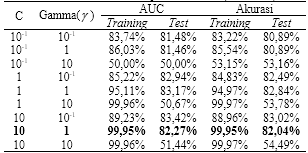

Berdasarkan hasil tersebut, diketahui bahwa nilai parameter terbaik yaitu nilai parameter C sebesar 10 dan nilai Gamma sebesar 1. Hasil tersebut, menunjukkan bahwa antara metode Grid Search dan perhitungan secara manual satu persatu kombinasi, memberikan hasil bahwa terdapat perbedaan, dimana nilai akurasi dan nilai AUC terbaik diperoleh dengan nilai parameter C = 10 dan Gamma = 1.